In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

userList = np.load('../data/netflix/netflix_userList.npy')
itemList = np.load('../data/netflix/netflix_itemList.npy')

total_usr = len(userList)
total_item = len(itemList)

user_map = get_map(userList)
item_map = get_map(itemList)

train_rating_all = np.load('../data/netflix/train_rating_all.npy')

import pickle

train_indices_all = None
test_indices_all = None

with open('../data/netflix/train_indices_all.pkl', 'rb') as train_indice_file:
    train_indices_all = pickle.load(train_indice_file)
    train_indice_file.close()
    
with open('../data/netflix/test_indices_all.pkl', 'rb') as test_indice_file:
    test_indices_all = pickle.load(test_indice_file)
    test_indice_file.close()

In [3]:
df = pd.read_csv('../data/itri/rating_itri_pruned.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5
df_array = df.as_matrix()

userList = sorted(df['uid'].unique())
itemList = sorted(df['iid'].unique())

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

user_map = get_map(userList)
item_map = get_map(itemList)
    

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d, num. of ratings: %d" % (total_usr, total_item, len(df)))

sparsity of ratings is 5.16%
num. of users: 276, num. of items: 989, num. of ratings: 14072


# Clustering

In [27]:
user_vectors = np.load('../data/itri/feature_vectors.npy')
pca = PCA(n_components=2, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
colors = np.random.rand(len(pca_out[:, 0]))


plt.scatter(pca_out[:, 0], pca_out[:, 1], c=colors, alpha=0.5)
plt.savefig('figs/i_feature_vecPCA_scatter.jpg')
plt.gcf().clear()

In [28]:
user_vectors = np.load('../data/itri/feature_vectors.npy')
pca = PCA(n_components=10, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
NUM_CLUSTER = 10
kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=10, algorithm='full')


kmeans.fit(pca_out)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
label_map = {}
for i in kmeans.labels_:
    if i not in label_map:
        label_map[i] = 1
    else:
        label_map[i] += 1

print (label_map)

{4: 23, 1: 145, 5: 19, 7: 8, 8: 15, 9: 4, 6: 14, 2: 15, 3: 16, 0: 17}


In [30]:
label_index = {}
for i in range(NUM_CLUSTER):
    label_index[i] = []
    
label_list = list(kmeans.labels_)

for idx, i in enumerate(label_list):
    label_index[i].append(idx)

rating = np.zeros((total_usr, total_item), dtype=np.int8)
for line in df_array:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    rating[uid, iid] = 1

In [31]:
test_aps_5 = []
test_aps_10 = []
test_rec_5 = []
test_rec_10 = []

for i in range(NUM_CLUSTER):
    print ("Cluster %d." % (i))
    train_rating = np.take(train_rating_all, label_index[i], axis=0)
    train_user = label_index[i]
    # train_rating, train_indices, test_indices = gen_train_test(rating_n)
    # train_rating = np.take(rating, label_index[i], axis=0)
    train_indices = np.take(train_indices_all, label_index[i])
    test_indices = np.take(test_indices_all, label_index[i])
    
    tf.reset_default_graph()

    autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                              batch_size=1, epochs=200)
    autoencoder.model_load(0)
    autoencoder.train(rating=train_rating,
                      train_idents=train_user,
                      train_indices=train_indices,
                      test_indices=test_indices)
    
    """autoencoder.train(rating=rating,
                     train_idents=train_user)"""
    
    test_ap_5 = autoencoder.log['ap@5']
    test_ap_10 = autoencoder.log['ap@10']
    recs_5 = autoencoder.log['recall@5']
    recs_10 = autoencoder.log['recall@10']
    
    # top_N_ap = sorted(test_ap,reverse=True)[:20]
    # test_aps.append(np.mean(top_N_ap))
    
    test_aps_5.append(max(test_ap_5))
    test_aps_10.append(max(test_ap_10))
    test_rec_5.append(max(recs_5))
    test_rec_10.append(max(recs_10))
    
    """plt.plot(range(len(test_ap_10)), test_ap_10, color='green', label='Test AP')
    # plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
    plt.legend(loc="upper right")
    plt.title("Train 200 epoch")
    plt.xlabel('#Epoch')
    plt.ylabel('AP_10')
    plt.savefig('./figs/test_ap_cluster_%d.jpg' % (i))
    plt.gcf().clear()"""
    

Cluster 0.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:05<00:00, 37.07it/s]


Cluster 1.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


Cluster 2.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:04<00:00, 43.93it/s]


Cluster 3.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:03<00:00, 51.07it/s]


Cluster 4.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:04<00:00, 40.20it/s]


Cluster 5.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:04<00:00, 48.78it/s]


Cluster 6.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:03<00:00, 51.34it/s]


Cluster 7.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:02<00:00, 78.40it/s]


Cluster 8.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:03<00:00, 54.21it/s]


Cluster 9.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:00<00:00, 209.34it/s]


In [32]:
ap_5 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap_5 += test_aps_5[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps_5[i], num, test_aps_5[i]*num))
    
ap_5 = ap_5 / (total_usr)

print ("Over all average ap: %f" % (ap_5))

Cluster 0, aps: 0.220196, num: 17, weighted ap: 3.743333
Cluster 1, aps: 0.046546, num: 145, weighted ap: 6.749167
Cluster 2, aps: 0.531778, num: 15, weighted ap: 7.976667
Cluster 3, aps: 0.318333, num: 16, weighted ap: 5.093333
Cluster 4, aps: 0.065797, num: 23, weighted ap: 1.513333
Cluster 5, aps: 0.064561, num: 19, weighted ap: 1.226667
Cluster 6, aps: 0.526667, num: 14, weighted ap: 7.373333
Cluster 7, aps: 0.588333, num: 8, weighted ap: 4.706667
Cluster 8, aps: 0.516889, num: 15, weighted ap: 7.753333
Cluster 9, aps: 0.145833, num: 4, weighted ap: 0.583333
Over all average ap: 0.169272


In [33]:
ap_10 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap_10 += test_aps_10[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps_10[i], num, test_aps_10[i]*num))
    
ap_10 = ap_10 / (total_usr)

print ("Over all average ap: %f" % (ap_10))

Cluster 0, aps: 0.146338, num: 17, weighted ap: 2.487738
Cluster 1, aps: 0.046962, num: 145, weighted ap: 6.809464
Cluster 2, aps: 0.447008, num: 15, weighted ap: 6.705119
Cluster 3, aps: 0.241429, num: 16, weighted ap: 3.862857
Cluster 4, aps: 0.040496, num: 23, weighted ap: 0.931402
Cluster 5, aps: 0.043789, num: 19, weighted ap: 0.831984
Cluster 6, aps: 0.360910, num: 14, weighted ap: 5.052738
Cluster 7, aps: 0.471101, num: 8, weighted ap: 3.768810
Cluster 8, aps: 0.377058, num: 15, weighted ap: 5.655873
Cluster 9, aps: 0.103472, num: 4, weighted ap: 0.413889
Over all average ap: 0.132318


In [34]:
recall_5 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    recall_5 += test_rec_5[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_rec_5[i], num, test_rec_5[i]*num))
    
recall_5 = recall_5 / (total_usr)

print ("Over all average ap: %f" % (recall_5))

Cluster 0, aps: 0.305882, num: 17, weighted ap: 5.200000
Cluster 1, aps: 0.080805, num: 145, weighted ap: 11.716667
Cluster 2, aps: 0.613333, num: 15, weighted ap: 9.200000
Cluster 3, aps: 0.412500, num: 16, weighted ap: 6.600000
Cluster 4, aps: 0.121739, num: 23, weighted ap: 2.800000
Cluster 5, aps: 0.126316, num: 19, weighted ap: 2.400000
Cluster 6, aps: 0.600000, num: 14, weighted ap: 8.400000
Cluster 7, aps: 0.675000, num: 8, weighted ap: 5.400000
Cluster 8, aps: 0.586667, num: 15, weighted ap: 8.800000
Cluster 9, aps: 0.200000, num: 4, weighted ap: 0.800000
Over all average ap: 0.222162


In [35]:
recall_10 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    recall_10 += test_rec_10[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_rec_10[i], num, test_rec_10[i]*num))
    
recall_10 = recall_10 / (total_usr)

print ("Over all average ap: %f" % (recall_10))

Cluster 0, aps: 0.270588, num: 17, weighted ap: 4.600000
Cluster 1, aps: 0.105153, num: 145, weighted ap: 15.247222
Cluster 2, aps: 0.546667, num: 15, weighted ap: 8.200000
Cluster 3, aps: 0.368750, num: 16, weighted ap: 5.900000
Cluster 4, aps: 0.095221, num: 23, weighted ap: 2.190079
Cluster 5, aps: 0.141813, num: 19, weighted ap: 2.694444
Cluster 6, aps: 0.457143, num: 14, weighted ap: 6.400000
Cluster 7, aps: 0.600000, num: 8, weighted ap: 4.800000
Cluster 8, aps: 0.480000, num: 15, weighted ap: 7.200000
Cluster 9, aps: 0.175000, num: 4, weighted ap: 0.700000
Over all average ap: 0.209898


# Old

### For netflix huge dataset

user_train_rating = np.load('../data/netflix/rating_matrix_CDAE.npy')

train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

import pickle

np.save('../data/netflix/train_rating_all.npy', train_rating_all)

with open('../data/netflix/train_indices_all.pkl', 'wb') as train_indice_file:
    pickle.dump(train_indices_all, train_indice_file)
    
with open('../data/netflix/test_indices_all.pkl', 'wb') as test_indice_file:
    pickle.dump(test_indices_all, test_indice_file)

### For others

In [4]:
train_data = df.as_matrix()

user_train_rating = np.zeros((total_usr, total_item), dtype=np.int32)

for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1

In [5]:
topN = np.count_nonzero(user_train_rating, axis=0).argsort()[::-1][:10]
others = [k for k in range(total_item) if k not in topN]

train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

tf.reset_default_graph()

train_user_all = np.nonzero(np.count_nonzero(train_rating_all, axis=1))[0]

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', denoise_function='dropout', 
                          loss_function='cross_entropy', batch_size=1, epochs=500)


specify_vector_original = autoencoder.sess.run(autoencoder.vector_matrix)

import sklearn.metrics as metrics

vector = {'i': -1, 'j': -1}

max_sim = 0
min_sim = 1

for i in range(train_rating_all.shape[0]):
    for j in range(i+1, train_rating_all.shape[0]):
        sim_i_j = metrics.pairwise.cosine_similarity(
            [train_rating_all[i]], [train_rating_all[j]])
        
        if sim_i_j == 0:
            min_sim = sim_i_j
            spec_sim_i_j = metrics.pairwise.cosine_similarity(
                [specify_vector_original[i]], [specify_vector_original[j]])
            
            if spec_sim_i_j > max_sim:
                max_sim = spec_sim_i_j
                vector['i'] = i
                vector['j'] = j
                print (i, j)
            
            

not_sim_list = [(137, 251), (198, 718), (234, 387), (380, 826), (442, 677)]
not_sim_spec_vector = np.take(specify_vector_original, not_sim_list, axis=0)

simlarity_org_list = [metrics.pairwise.cosine_similarity(
    [x[0]], [x[1]])[0][0] for x in not_sim_spec_vector]

autoencoder.train(rating=train_rating_all,
                  train_idents=train_user_all,
                  train_indices=train_indices_all,
                  test_indices=test_indices_all,
                  topN=None,
                  weight=None)

specify_vector_trained = autoencoder.sess.run(autoencoder.vector_matrix)

not_sim_spec_vector_trained = np.take(specify_vector_trained, not_sim_list, axis=0)

simlarity_trained_list = [metrics.pairwise.cosine_similarity(
    [x[0]], [x[1]])[0][0] for x in not_sim_spec_vector_trained]

print (simlarity_trained_list)

print (simlarity_org_list)

not_sim_list_ = ['(137, 251)', '(198, 718)', '(234, 387)', '(380, 826)']

x = np.array([0,1,2,3])

plt.xticks(x, not_sim_list_)

plt.plot(x, simlarity_org_list[:-1], color='green', marker='o', label='similarity_orginal')
plt.plot(x, simlarity_trained_list[:-1], color='red', marker='x', label='similarity_trained')
plt.legend(loc="lower right")
plt.title("Specify vector similarity changes.")
plt.xlabel('Not similar user pair')
plt.ylabel('Cosine Similarity')
plt.savefig('./figs/Spevector_sim_changes.jpg')
plt.show()
plt.gcf().clear()

## old

In [10]:
train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

tf.reset_default_graph()

train_user_all = np.nonzero(np.count_nonzero(train_rating_all, axis=1))[0]

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', denoise_function='dropout', 
                          loss_function='cross_entropy', batch_size=1, epochs=200)


autoencoder.train(rating=train_rating_all,
                  train_idents=train_user_all,
                  train_indices=train_indices_all,
                  test_indices=test_indices_all,
                  topN=None,
                  weight=None)

autoencoder.model_save(0)

100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


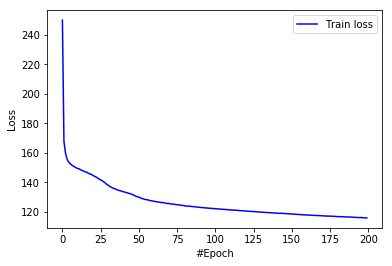

In [11]:
train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
test_ap_5 = autoencoder.log['ap@5']
test_ap_10 = autoencoder.log['ap@10']

"""plt.plot(range(5, (len(test_ap)+1)*5, 5), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()"""

# print (np.mean(top_N_ap))

print ("AP@5: ", max(test_ap_5))
print ("AP@10: ", max(test_ap_10))

AP@5:  0.13949376006441236
AP@10:  0.11334636115584189


In [13]:
test_recall_5 = autoencoder.log['recall@5']
test_recall_10 = autoencoder.log['recall@10']

"""plt.plot(range(5, (len(test_recall)+1)*5, 5), test_recall, color='green', label='Test Recall')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('Recall')
plt.show()"""

# print (np.mean(top_N_ap))

print ("Recall@5: ", max(test_recall_5))
print ("Recall@10: ", max(test_recall_10))

Recall@5:  0.18810386473429963
Recall@10:  0.1833836553945252


In [ ]:
tf.reset_default_graph()
autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                          batch_size=100, epochs=1000)
autoencoder.model_load(0)

In [14]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)
u_vectors = np.load('../data/itri/user_vectors.npy')

In [15]:
feature_vectors = np.zeros((total_usr, 20), dtype=np.float32)
for i in range(total_usr):
    feature_vectors[i] = autoencoder.sess.run(
        autoencoder.code,
        feed_dict={
            autoencoder.input: [train_rating_all[i]],
            autoencoder.ident: [i]
        })
    
np.save('../data/itri/feature_vectors.npy', feature_vectors)

In [17]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)

np.save('../data/itri/user_vectors.npy', user_onehot_vectors)